In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import calendar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm
import imageio
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
t2m_wf = xr.open_dataset('/nird/datalake/NS1004K/elihho/tes0004_echam6_BOT_mm_0_1850_var167.nc')
t2m_wof = xr.open_dataset('/nird/datalake/NS1004K/elihho/slo0059_echam6_BOT_mm_0_1850_var167.nc')
t2m_wf

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 21960, lon: 192, lat: 96)
Coordinates:
  * time     (time) float64 176kB 7.001e+07 7.001e+07 ... 8.85e+07 8.85e+07
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 768B 88.57 86.72 84.86 83.0 ... -84.86 -86.72 -88.57
Data variables:
    var167   (time, lat, lon) float32 2GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Sep 07 15:33:01 2020: cdo cat tes0004__echam6_BOT_mm_70...
    institution:  Max-Planck-Institute for Meteorology
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

In [3]:
# For t2m_wf
n_months_wf = t2m_wf.sizes['time']
years_wf = np.floor_divide(np.arange(n_months_wf), 12)
months_wf = (np.remainder(np.arange(n_months_wf), 12) + 1)
cftime_time_wf = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wf, months_wf)]
t2m_wf = t2m_wf.assign_coords(time=("time", cftime_time_wf))

# For t2m_wof
n_months_wof = t2m_wof.sizes['time']
years_wof = np.floor_divide(np.arange(n_months_wof), 12)
months_wof = (np.remainder(np.arange(n_months_wof), 12) + 1)
cftime_time_wof = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wof, months_wof)]
t2m_wof = t2m_wof.assign_coords(time=("time", cftime_time_wof))

In [4]:
# Split seasons
t2m_wf_DJF = t2m_wf['var167'][0::4,:,:]
t2m_wf_JJA = t2m_wf['var167'][2::4,:,:]

t2m_wof_DJF = t2m_wof['var167'][0::4,:,:]
t2m_wof_JJA = t2m_wof['var167'][2::4,:,:]

In [5]:
start_year = 1251
end_year = 1850

In [6]:
t2m_wf_lia = t2m_wf.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
t2m_wof_lia = t2m_wof.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

In [7]:
# Simple average
global_mean_lia_wf = t2m_wf_lia['var167'].mean(dim=['lat', 'lon'])
global_mean_lia_wof = t2m_wof_lia['var167'].mean(dim=['lat', 'lon'])

rolling_years = 1
rolling_months = rolling_years * 12

smoothed_global_mean_wf = global_mean_lia_wf.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_wof = global_mean_lia_wof.rolling(time=rolling_months, center=True).mean()

In [8]:
scand_lat = slice(89, 0)
#scand_lon = slice(-10, 50)

scand_lia_wf = t2m_wf_lia['var167'].sel(lat=scand_lat).mean(dim=['lat', 'lon'])
scand_lia_wof = t2m_wof_lia['var167'].sel(lat=scand_lat).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf = scand_lia_wf.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof = scand_lia_wof.rolling(time=rolling_months, center=True).mean()


In [9]:
task = pd.read_csv('Marshall_et_al_2024_Data_TASK_Global.csv', sep=',')
task_NH = pd.read_csv("Marshall_et_al_2024_Data_TASK_NHMJJA.csv", sep=',')
task_NH

,Year,UKESM1 r1,UKESM1 r2,UKESM1 r3,CESM2(WACCM6ma),MPI-ESM1-2-LR r1,MPI-ESM1-2-LR r2,MRI-ESM2,MIROC-ES2L,IPSL-CM6A-LR
0,1250,285.424,284.914,285.351,285.871,284.660,284.315,286.258,286.994,285.139
1,1251,285.195,285.377,284.947,285.360,284.378,285.197,286.149,287.293,285.041
2,1252,284.849,284.963,285.316,284.928,284.975,284.516,285.706,287.292,285.286
3,1253,285.252,285.262,285.430,285.211,284.737,284.779,286.246,287.223,284.839
4,1254,285.391,285.339,285.342,285.512,284.278,284.738,286.150,287.502,285.272
...,...,...,...,...,...,...,...,...,...,...
595,1845,285.555,285.331,285.079,284.529,284.761,284.580,286.000,287.024,284.651
596,1846,285.051,284.839,285.254,284.941,284.966,284.337,286.784,287.054,284.693
597,1847,285.319,284.892,285.463,285.436,284.752,284.547,286.156,286.777,284.284
598,1848,284.833,284.506,285.027,284.890,285.175,285.211,285.921,286.783,284.231


In [10]:
tas_orb_GHG = xr.open_dataset('slo0043_echam6_BOT_mm_1001-8850_167_NH.nc')
tas_all_forcing = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_167_NH.nc')

# === Fix TIME for orb_GHG ===
n_months_wf = tas_orb_GHG.sizes['time']
start_year_wf = 1850 - (n_months_wf // 12)  # reverse from last year
years_wf = np.floor_divide(np.arange(n_months_wf), 12) + start_year_wf
months_wf = (np.remainder(np.arange(n_months_wf), 12) + 1)
cftime_time_wf = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wf, months_wf)]
tas_orb_GHG = tas_orb_GHG.assign_coords(time=("time", cftime_time_wf))

# === Fix TIME for all_forcing ===
n_months_wof = tas_all_forcing.sizes['time']
start_year_wof = 1850 - (n_months_wof // 12)
years_wof = np.floor_divide(np.arange(n_months_wof), 12) + start_year_wof
months_wof = (np.remainder(np.arange(n_months_wof), 12) + 1)
cftime_time_wof = [cftime.DatetimeNoLeap(int(y), int(m), 1) for y, m in zip(years_wof, months_wof)]
tas_all_forcing = tas_all_forcing.assign_coords(time=("time", cftime_time_wof))


tas_orb_GHG_lia = tas_orb_GHG.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
tas_all_forcing_lia = tas_all_forcing.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

orb_GHG_lia = tas_orb_GHG_lia['var167'].sel(lat=scand_lat).mean(dim=['lat', 'lon'])
all_forcing_lia = tas_all_forcing_lia['var167'].sel(lat=scand_lat).mean(dim=['lat', 'lon'])

orb_GHG_smooth = orb_GHG_lia.rolling(time=rolling_months, center=True).mean()
all_forcing_smooth = all_forcing_lia.rolling(time=rolling_months, center=True).mean()

tas_orb_GHG

<xarray.Dataset> Size: 3GB
Dimensions:  (lon: 192, lat: 48, time: 94200)
Coordinates:
  * lon      (lon) float64 2kB -180.0 -178.1 -176.2 -174.4 ... 174.4 176.2 178.1
  * lat      (lat) float64 384B 88.57 86.72 84.86 83.0 ... 4.663 2.798 0.9326
  * time     (time) object 754kB -6000-01-01 00:00:00 ... 1849-12-01 00:00:00
Data variables:
    var167   (time, lat, lon) float32 3GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.10 (https://mpimet.mpg.d...
    Conventions:  CF-1.6
    institution:  Max Planck Institute for Meteorology
    history:      Tue Mar 22 11:15:59 2022: cdo sellonlatbox,-180,180,0,90 sl...
    CDO:          Climate Data Operators version 1.9.10 (https://mpimet.mpg.d...

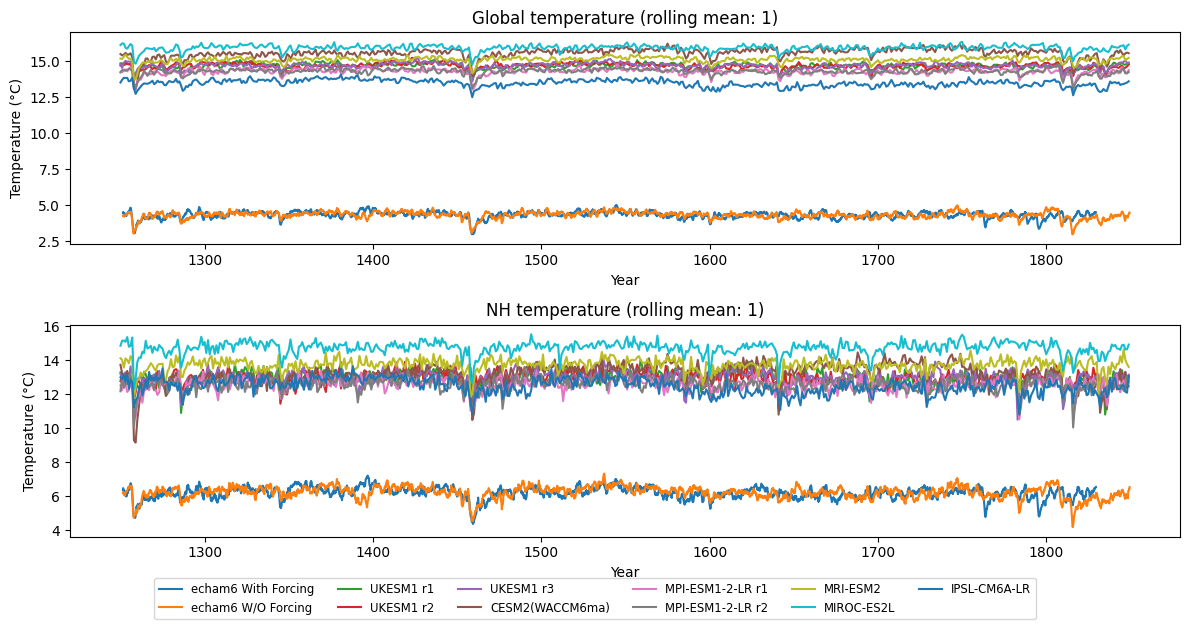

In [11]:
# Extract decimal years from cftime time coordinate
def cftime_to_decimal_year(time_array):
    years = np.array([t.year for t in time_array])
    months = np.array([t.month for t in time_array])
    # Approximate decimal year (month/12)
    decimal_years = years + (months - 1) / 12
    return decimal_years

x_wf = cftime_to_decimal_year(smoothed_global_mean_wf['time'].values)
x_wof = cftime_to_decimal_year(smoothed_global_mean_wof['time'].values)

x_scand_wf = cftime_to_decimal_year(scand_smoothed_wf['time'].values)
x_scand_wof = cftime_to_decimal_year(scand_smoothed_wof['time'].values)

fig, ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(x_wf, smoothed_global_mean_wf - 273.15, label='echam6 With Forcing')
ax[0].plot(x_wof, smoothed_global_mean_wof - 273.15, label='echam6 W/O Forcing')
for col in task.columns:
    if col not in ['Date', 'Year']:
        ax[0].plot(task['Year'], task[col]-272.15, label=col)
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global temperature (rolling mean: {rolling_years})')

ax[1].plot(x_scand_wf, scand_smoothed_wf - 273.15, label='echam6 With Forcing')
ax[1].plot(x_scand_wof, scand_smoothed_wof - 273.15, label='echam6 W/O Forcing')
for col in task_NH.columns:
    if col not in ['Date', 'Year']:
        ax[1].plot(task_NH['Year'], task_NH[col]-272.15, label=col)
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'NH temperature (rolling mean: {rolling_years})')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

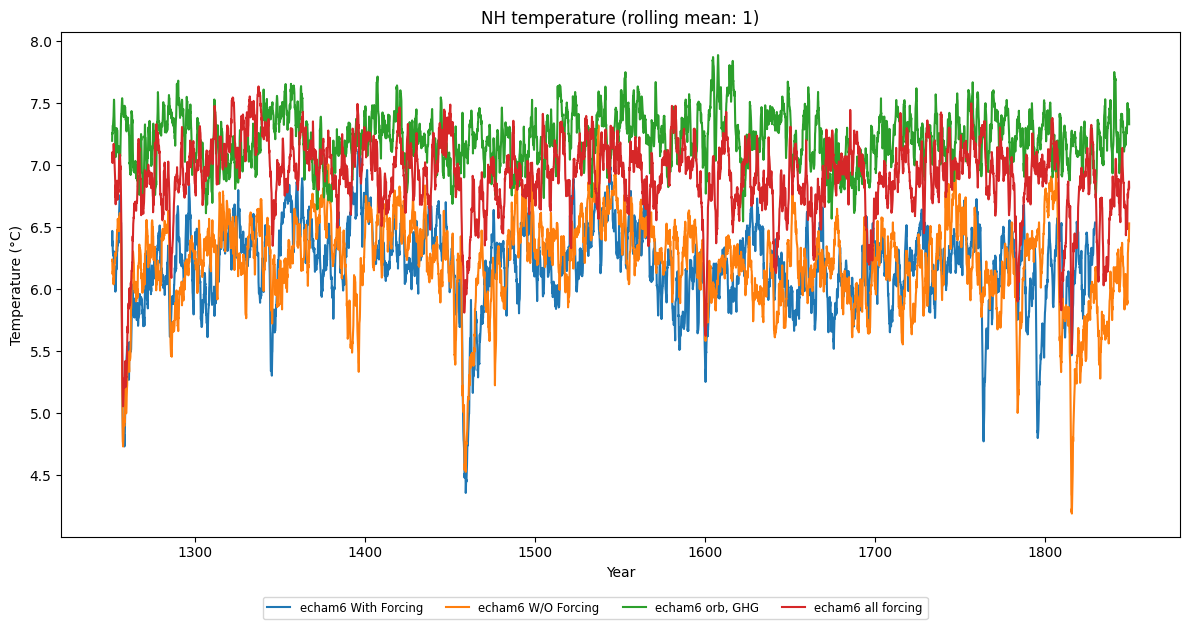

In [12]:
x_scand_wf = cftime_to_decimal_year(scand_smoothed_wf['time'].values)
x_scand_wof = cftime_to_decimal_year(scand_smoothed_wof['time'].values)

x_orb_GHG = cftime_to_decimal_year(orb_GHG_smooth['time'].values)
x_all_forcing = cftime_to_decimal_year(all_forcing_smooth['time'].values)

fig, ax = plt.subplots(figsize=(12,6))


ax.plot(x_scand_wf, scand_smoothed_wf - 273.15, label='echam6 With Forcing')
ax.plot(x_scand_wof, scand_smoothed_wof - 273.15, label='echam6 W/O Forcing')
ax.plot(x_orb_GHG, orb_GHG_smooth - 273.15, label='echam6 orb, GHG')
ax.plot(x_all_forcing, all_forcing_smooth - 273.15, label='echam6 all forcing')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
ax.set_title(f'NH temperature (rolling mean: {rolling_years})')

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

In [13]:
scand_lat = slice(89, 0)
scand_lon = slice(-10, 50)

scand_lia_wf = t2m_wf_lia['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])
scand_lia_wof = t2m_wof_lia['var167'].sel(lat=scand_lat, lon = scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf = scand_lia_wf.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof = scand_lia_wof.rolling(time=rolling_months, center=True).mean()

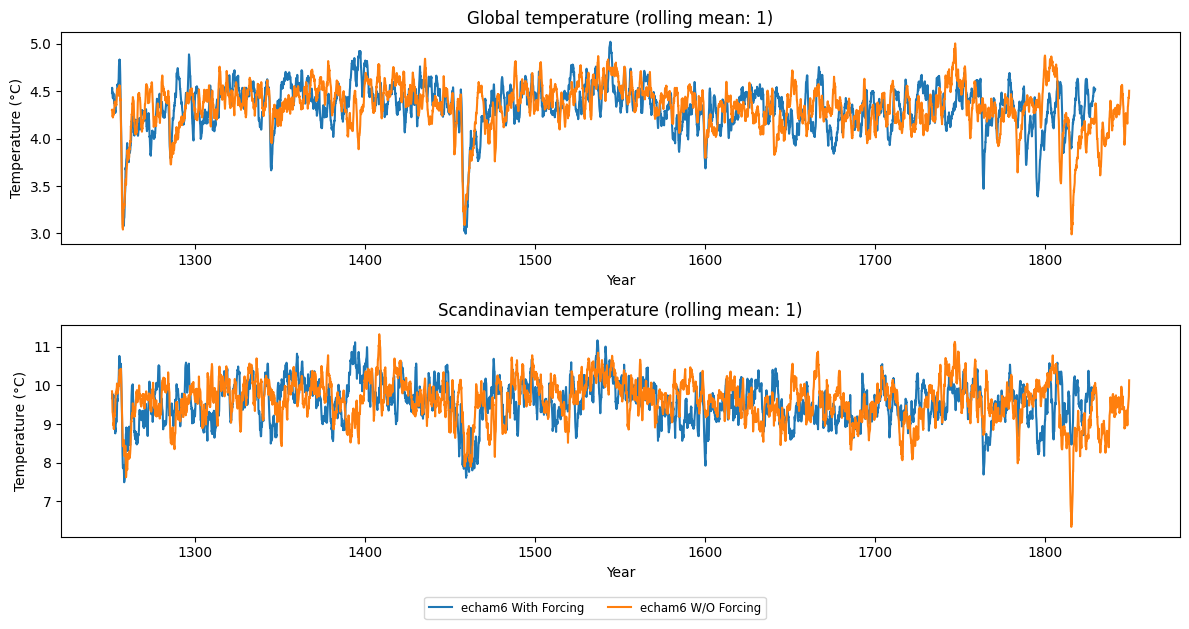

In [14]:
x_wf = cftime_to_decimal_year(smoothed_global_mean_wf['time'].values)
x_wof = cftime_to_decimal_year(smoothed_global_mean_wof['time'].values)

x_scand_wf = cftime_to_decimal_year(scand_smoothed_wf['time'].values)
x_scand_wof = cftime_to_decimal_year(scand_smoothed_wof['time'].values)

fig, ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(x_wf, smoothed_global_mean_wf - 273.15, label='echam6 With Forcing')
ax[0].plot(x_wof, smoothed_global_mean_wof - 273.15, label='echam6 W/O Forcing')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global temperature (rolling mean: {rolling_years})')

ax[1].plot(x_scand_wf, scand_smoothed_wf - 273.15, label='echam6 With Forcing')
ax[1].plot(x_scand_wof, scand_smoothed_wof - 273.15, label='echam6 W/O Forcing')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'Scandinavian temperature (rolling mean: {rolling_years})')

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=2,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()

In [15]:
def cftime_to_decimal_year(dates):
    decimal_years = []
    for date in dates:
        year = date.year
        start_of_year = cftime.DatetimeNoLeap(year, 1, 1)
        delta = date - start_of_year
        decimal_year = year + delta.days / 365
        decimal_years.append(decimal_year)
    return np.array(decimal_years)


In [16]:
start_year = 1251
end_year = 1850
t2m_wf_lia_DJF = t2m_wf_DJF.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
t2m_wof_lia_DJF = t2m_wof_DJF.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

In [17]:
# Simple average
global_mean_lia_wf_DJF = t2m_wf_lia_DJF.mean(dim=['lat', 'lon'])
global_mean_lia_wof_DJF = t2m_wof_lia_DJF.mean(dim=['lat', 'lon'])

smoothed_global_mean_wf_DJF = global_mean_lia_wf_DJF.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_wof_DJF = global_mean_lia_wof_DJF.rolling(time=rolling_months, center=True).mean()

In [18]:
scand_lia_wf_DJF = t2m_wf_lia_DJF.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])
scand_lia_wof_DJF = t2m_wof_lia_DJF.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf_DJF = scand_lia_wf_DJF.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof_DJF = scand_lia_wof_DJF.rolling(time=rolling_months, center=True).mean()

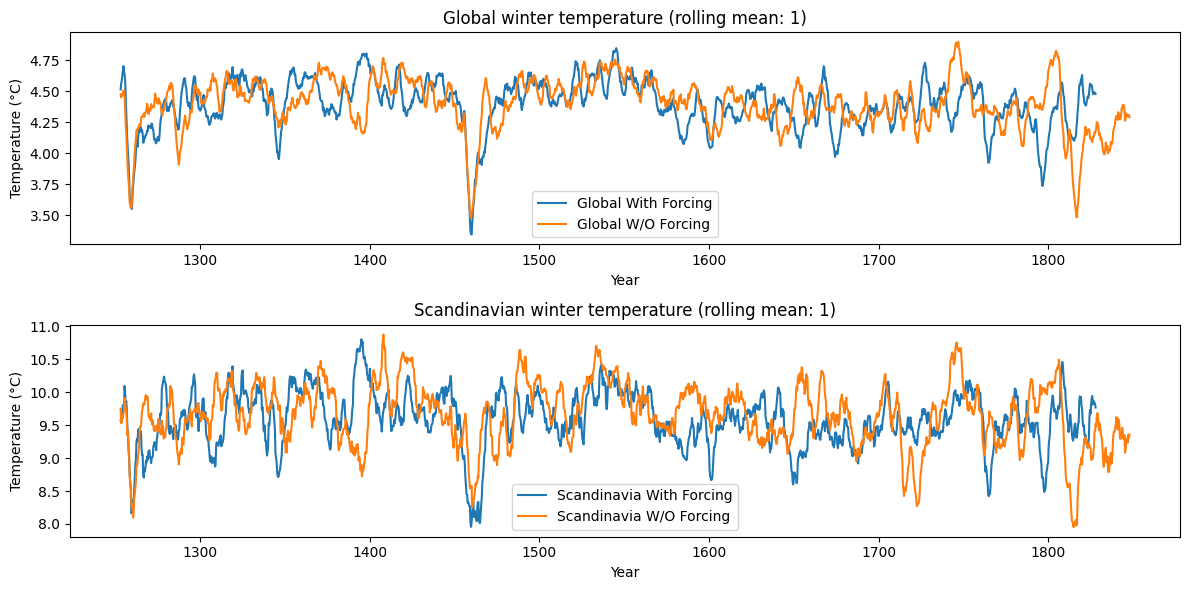

In [19]:
x_wf_DJF = cftime_to_decimal_year(smoothed_global_mean_wf_DJF.time.values)
x_wof_DJF = cftime_to_decimal_year(smoothed_global_mean_wof_DJF.time.values)

x_scand_wf_DJF = cftime_to_decimal_year(scand_smoothed_wf_DJF.time.values)
x_scand_wof_DJF = cftime_to_decimal_year(scand_smoothed_wof_DJF.time.values)


fig, ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(x_wf_DJF, smoothed_global_mean_wf_DJF - 273.15, label='Global With Forcing')
ax[0].plot(x_wof_DJF, smoothed_global_mean_wof_DJF - 273.15, label='Global W/O Forcing')
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global winter temperature (rolling mean: {rolling_years})')

ax[1].plot(x_scand_wf_DJF, scand_smoothed_wf_DJF - 273.15, label='Scandinavia With Forcing')
ax[1].plot(x_scand_wof_DJF, scand_smoothed_wof_DJF - 273.15, label='Scandinavia W/O Forcing')
ax[1].legend()
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'Scandinavian winter temperature (rolling mean: {rolling_years})')

plt.tight_layout()
plt.show()

In [20]:
t2m_wf_lia_JJA = t2m_wf_JJA.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
t2m_wof_lia_JJA = t2m_wof_JJA.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))

In [21]:
# Simple average
global_mean_lia_wf_JJA = t2m_wf_lia_JJA.mean(dim=['lat', 'lon'])
global_mean_lia_wof_JJA = t2m_wof_lia_JJA.mean(dim=['lat', 'lon'])

smoothed_global_mean_wf_JJA = global_mean_lia_wf_JJA.rolling(time=rolling_months, center=True).mean()
smoothed_global_mean_wof_JJA = global_mean_lia_wof_JJA.rolling(time=rolling_months, center=True).mean()

In [22]:
scand_lia_wf_JJA = t2m_wf_lia_JJA.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])
scand_lia_wof_JJA = t2m_wof_lia_JJA.sel(lat=scand_lat, lon=scand_lon).mean(dim=['lat', 'lon'])

# Smooth with rolling mean
scand_smoothed_wf_JJA = scand_lia_wf_JJA.rolling(time=rolling_months, center=True).mean()
scand_smoothed_wof_JJA = scand_lia_wof_JJA.rolling(time=rolling_months, center=True).mean()

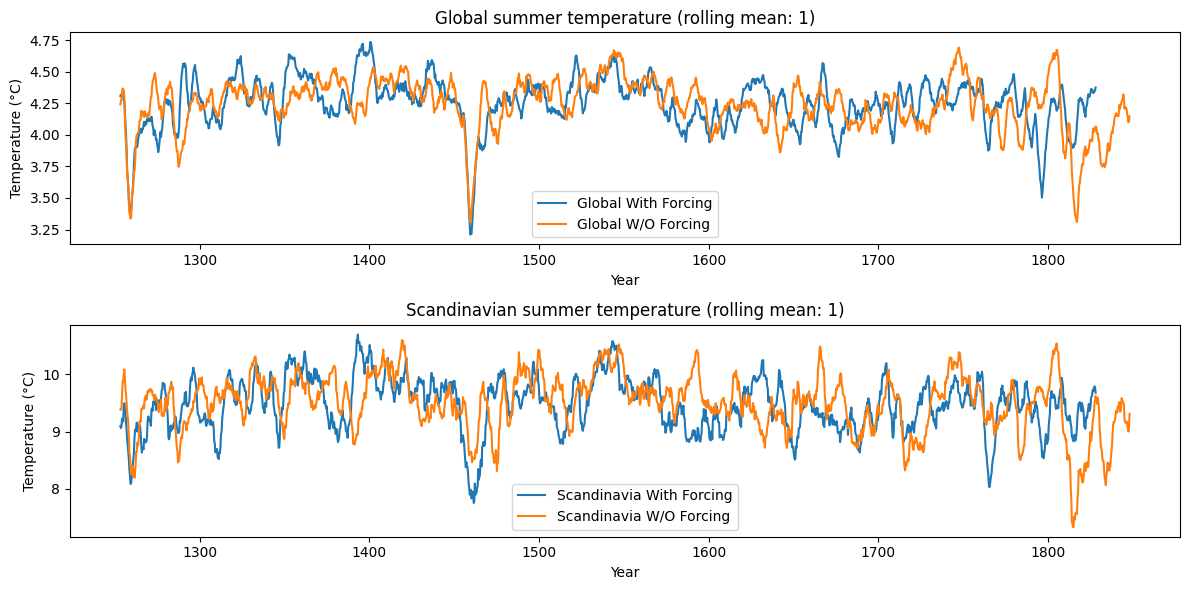

In [24]:
x_wf_JJA = cftime_to_decimal_year(smoothed_global_mean_wf_JJA['time'].values)
x_wof_JJA = cftime_to_decimal_year(smoothed_global_mean_wof_JJA['time'].values)

x_scand_wf_JJA = cftime_to_decimal_year(scand_smoothed_wf_JJA['time'].values)
x_scand_wof_JJA = cftime_to_decimal_year(scand_smoothed_wof_JJA['time'].values)

fig, ax = plt.subplots(2,1, figsize=(12,6))

ax[0].plot(x_wf_JJA, smoothed_global_mean_wf_JJA - 273.15, label='Global With Forcing')
ax[0].plot(x_wof_JJA, smoothed_global_mean_wof_JJA - 273.15, label='Global W/O Forcing')
ax[0].legend()
ax[0].set_xlabel('Year')
ax[0].set_ylabel('Temperature (°C)')
ax[0].set_title(f'Global summer temperature (rolling mean: {rolling_years})')

ax[1].plot(x_scand_wf_JJA, scand_smoothed_wf_JJA - 273.15, label='Scandinavia With Forcing')
ax[1].plot(x_scand_wof_JJA, scand_smoothed_wof_JJA - 273.15, label='Scandinavia W/O Forcing')
ax[1].legend()
ax[1].set_xlabel('Year')
ax[1].set_ylabel('Temperature (°C)')
ax[1].set_title(f'Scandinavian summer temperature (rolling mean: {rolling_years})')

plt.tight_layout()
plt.show()